# Hello everyone!

**Team Members**

* Zeyad Abdelwahab
* Maryam Mohamed Afifi
* Mayada Magdy Amin
* Aly Osama Othman
* Omar Hegazy Hegazy
* Mohaned Gamal Hussin

# 1. Import Libraries and Dataset

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import chi2_contingency, ttest_ind
import scipy.stats as stats
import warnings

warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv(r"C:\Users\Lenovo\Downloads\cleaned_data.csv")
df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results,Test Results Encoded
0,Bobby JacksOn,0.223684,1,5,2,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,0.380933,328,2,2024-02-02,3,2,0
1,LesLie TErRy,0.644737,1,0,5,2019-08-20,Samantha Davies,Kim Inc,Medicare,0.650904,265,1,2019-08-26,1,1,2
2,DaNnY sMitH,0.828947,0,1,5,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,0.547053,205,1,2022-10-07,0,2,0
3,andrEw waTtS,0.197368,0,6,3,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,0.728798,450,0,2020-12-18,1,0,1
4,adrIENNE bEll,0.394737,0,2,2,2022-09-19,Kathleen Hanna,White-White,Aetna,0.296622,458,2,2022-10-09,4,0,1


# 2. Data Cleaning

In [4]:
numeric_cols = ['Age', 'Billing Amount']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

power_transformer = PowerTransformer()
df[numeric_cols] = power_transformer.fit_transform(df[numeric_cols])

**addressing outliers**

In [5]:
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).sum()
print("\nOutliers per column (IQR method):\n", outliers_iqr)


Outliers per column (IQR method):
 Age               0
Billing Amount    0
dtype: int64


**Identifying and Fixing Unexpected Values**

In [6]:
df = df[(df['Age'] >= 0) & (df['Age'] <= 120)]

In [7]:
if 'test_result_encoded' not in df.columns:
    le = LabelEncoder()
    df['test_result_encoded'] = le.fit_transform(df['Test Results'])

In [8]:
# Convert 'Date of Admission' to datetime format
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'])

# Extract the year-month as a proper datetime object
df['Month'] = df['Date of Admission'].dt.to_period('M').astype(str)
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')

# Group by Month and count admissions
monthly_admissions = df.groupby('Month').size().reset_index(name='Admissions')

# Sort by date (just in case)
monthly_admissions = monthly_admissions.sort_values(by='Month')

# 3. Data Analysis

**Correlation Analysis**

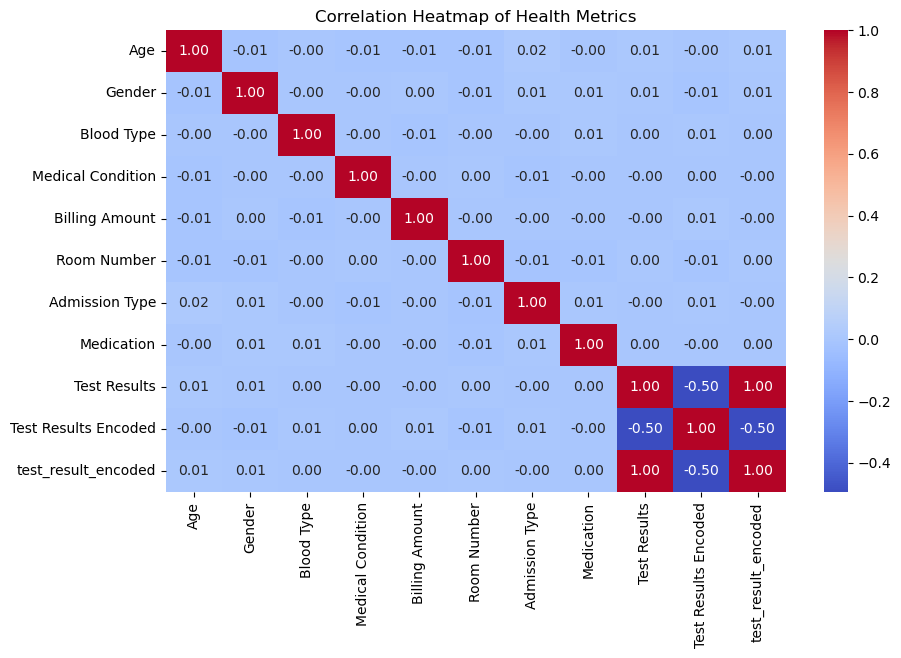

In [9]:
# Convert categorical columns to numeric for correlation analysis
df_numeric = df.select_dtypes(include=['number'])

# Compute correlation matrix
correlation_matrix = df_numeric.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Health Metrics")
plt.show()

**Hypothesis Testing**

In [10]:
# Group by Medical Condition and compare billing amounts
group1 = df[df['Medical Condition'] == 'diabetes']['Billing Amount']
group2 = df[df['Medical Condition'] == 'cancer']['Billing Amount']

# Perform t-test
stat, p_value = ttest_ind(group1, group2, equal_var=False)

print(f"T-Test Results: p-value = {p_value}")
if p_value < 0.05:
    print("🔴 Significant difference found between the groups!")
else:
    print("✅ No significant difference.")


T-Test Results: p-value = nan
✅ No significant difference.


In [11]:

# Create contingency table for Blood Type vs Medical Condition
contingency_table = pd.crosstab(df['Blood Type'], df['Medical Condition'])

# Perform Chi-Square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")

# Interpretation
if p < 0.05:
    print("🔹 Blood Type has a significant effect on Medical Condition.")
else:
    print("🔹 No strong evidence that Blood Type affects Medical Condition.")


Chi-Square Statistic: 30.98106361060314
P-Value: 0.6625766732530531
🔹 No strong evidence that Blood Type affects Medical Condition.


In [12]:
# Grouped analysis by Test Result
grouped = df.groupby('Test Results').mean(numeric_only=True)
display(grouped)

,Age,Gender,Blood Type,Medical Condition,Billing Amount,Room Number,Admission Type,Medication,Test Results Encoded,test_result_encoded
Test Results,,,,,,,,,,
0,0.854213,0.499038,3.475748,2.496688,-0.001111,301.655983,0.994551,1.985897,1.0,0.0
1,0.861880,0.496614,3.512560,2.499345,0.017301,300.071756,1.006116,1.985474,2.0,1.0
2,0.866425,0.505829,3.481082,2.496150,-0.012885,302.975143,0.992301,1.987352,0.0,2.0


# 4. Data Visualization

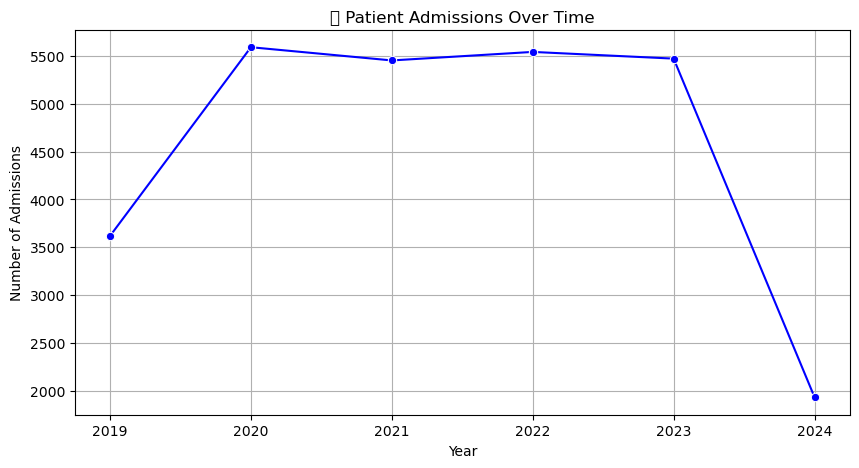

In [15]:
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'])  # Convert to datetime
df_trend = df.groupby(df['Date of Admission'].dt.year)['Name'].count()  # Count admissions per year

# Plot trend
plt.figure(figsize=(10, 5))
sns.lineplot(x=df_trend.index, y=df_trend.values, marker="o", color="blue")
plt.title("📈 Patient Admissions Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Admissions")
plt.grid(True)
plt.show()


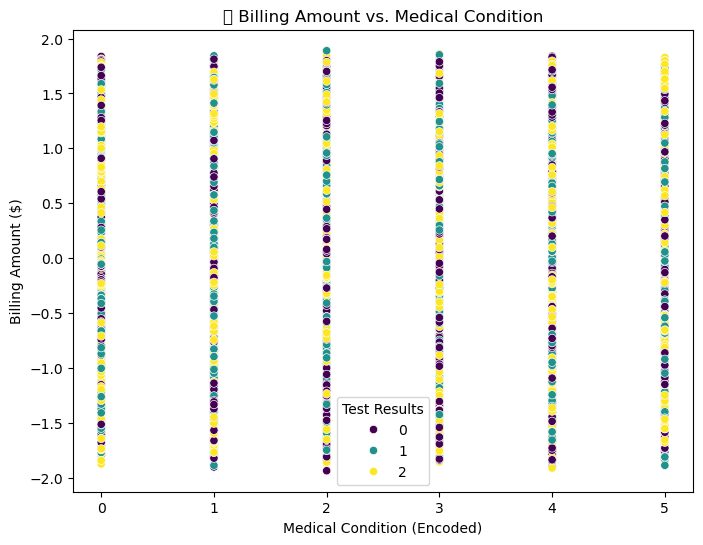

In [16]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Medical Condition", y="Billing Amount", hue="Test Results", palette="viridis")
plt.title("💰 Billing Amount vs. Medical Condition")
plt.xlabel("Medical Condition (Encoded)")
plt.ylabel("Billing Amount ($)")
plt.show()

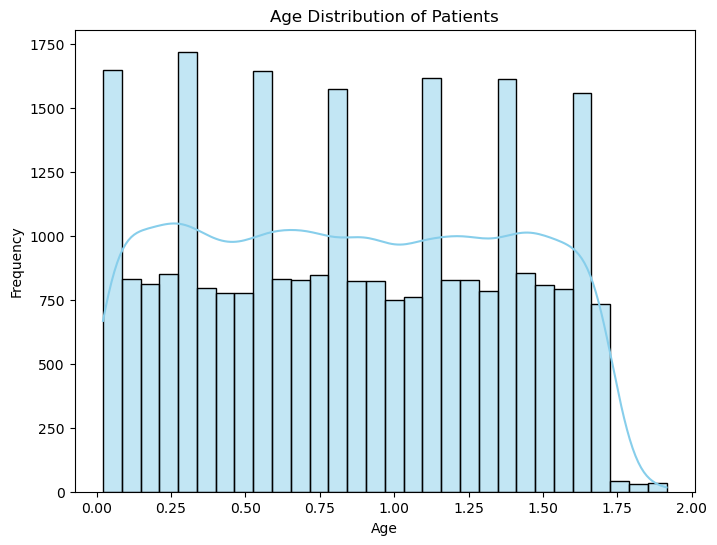

In [17]:
plt.figure(figsize=(8,6))
sns.histplot(df['Age'], bins=30, kde=True, color='skyblue')
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


In [18]:
print(df['Age'].unique())  # Check unique values in the Age column
print(df['Age'].describe())  # See min, max, mean, etc.

[0.53240568 1.24902274 1.55656455 0.32797075 1.04412343 1.19778776
 0.83933885 0.58353907 0.78816206 0.37906399 1.09533795 1.35151209
 0.94171607 0.27688849 1.14655944 1.50529254 0.68583323 1.30026423
 1.65912568 0.17475868 1.6078423  0.48128182 1.45402637 0.4301678
 1.40276618 0.0726785  0.89052359 1.71041457 0.02165847 0.12371211
 0.73699343 0.22581764 0.63468168 0.99291608 1.86431334 1.8130085
 1.76170888 1.9156233 ]
count    27608.000000
mean         0.860777
std          0.504067
min          0.021658
25%          0.430168
50%          0.839339
75%          1.300264
max          1.915623
Name: Age, dtype: float64


In [19]:
print(df['Gender'].value_counts())


Gender
1    13817
0    13791
Name: count, dtype: int64


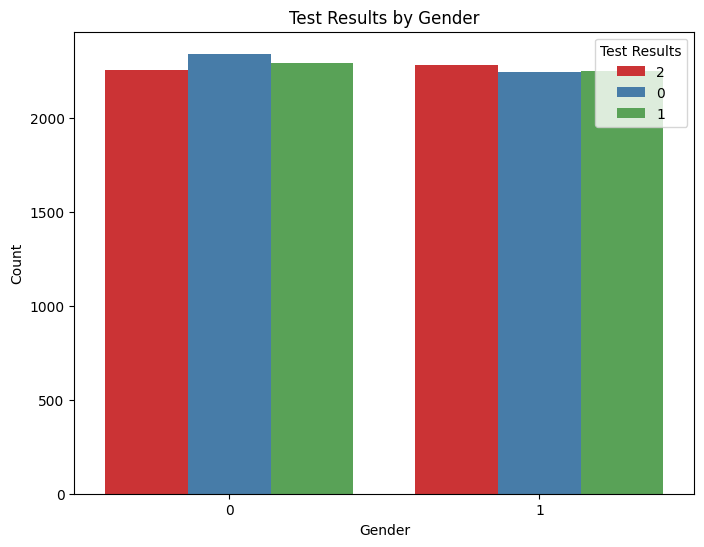

In [50]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='Gender', hue='Test Results', palette='Set1')
plt.title('Test Results by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Test Results')
plt.show()


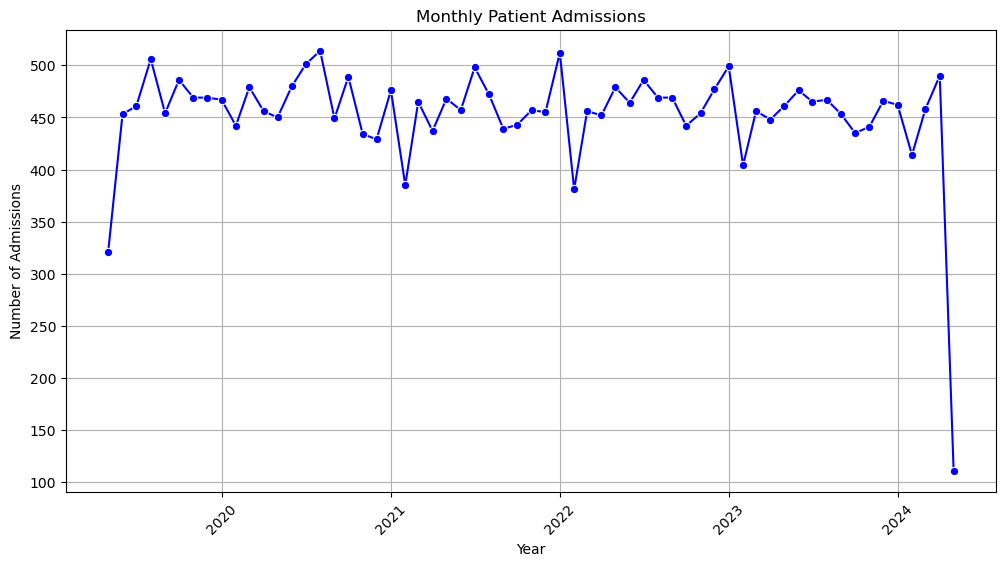

In [20]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_admissions, x='Month', y='Admissions', marker='o', color='blue')

# Formatting
plt.title('Monthly Patient Admissions')
plt.xlabel('Year')
plt.ylabel('Number of Admissions')
plt.xticks(rotation=45)  # Rotate for readability
plt.grid(True)

# Show Plot
plt.show()

In [21]:
df_numeric = df.select_dtypes(include=['number'])  # Keep only numeric columns

# Scatter Plot with Trendline
fig = px.scatter(df, x='Age', y='Billing Amount', trendline='ols', title='Age vs Billing Amount Trend')
fig.show()

# Interactive Heatmap (only numeric columns)
fig = go.Figure(data=go.Heatmap(z=df_numeric.corr().values,
                                x=df_numeric.columns,
                                y=df_numeric.columns,
                                colorscale='RdBu'))
fig.update_layout(title='Interactive Correlation Heatmap')
fig.show()